In [225]:
import numpy as np
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.spatial import KDTree
from geopy.distance import geodesic 

import pickle
from pprint import pprint
from typing import Any, Iterable, Optional, Tuple

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

In [226]:
def setup_ax(fig: matplotlib.figure.Figure,
             pos: Tuple[int, int, int] = (1, 1, 1),
             ) -> matplotlib.axes.Axes:
    '''
    Args
    - fig: matplotlib.figure.Figure
    - pos: 3-tuple of int, axes position (nrows, ncols, index)
    Returns: matplotlib.axes.Axes
    '''
    ax = fig.add_subplot(*pos, projection=ccrs.PlateCarree())

    # draw land (better version of cfeature.LAND)
    # land = cfeature.NaturalEarthFeature(
    #     category='physical', name='land', scale='10m',
    #     edgecolor='face', facecolor=cfeature.COLORS['land'], zorder=-1)
    ax.add_feature(cfeature.LAND)

    # draw borders of countries (better version of cfeature.BORDERS)
    countries = cfeature.NaturalEarthFeature(
        category='cultural', name='admin_0_boundary_lines_land', scale='10m',
        edgecolor='black', facecolor='none')
    ax.add_feature(countries)

    # draw coastline (better version of cfeature.COASTLINE)
    coastline = cfeature.NaturalEarthFeature(
        category='physical', name='coastline', scale='10m',
        edgecolor='black', facecolor='none')
    ax.add_feature(coastline)

    # draw lakes (better version of cfeature.LAKES)
    lakes = cfeature.NaturalEarthFeature(
        category='physical', name='lakes', scale='10m',
        edgecolor='face', facecolor=cfeature.COLORS['water'])
    ax.add_feature(lakes)

    # draw ocean (better version of cfeature.OCEAN)
    ocean = cfeature.NaturalEarthFeature(
        category='physical', name='ocean', scale='50m',
        edgecolor='face', facecolor=cfeature.COLORS['water'], zorder=-1)
    ax.add_feature(ocean)

    # draw rivers (better version of cfeature.RIVERS)
    rivers = cfeature.NaturalEarthFeature(
        category='physical', name='rivers_lake_centerlines', scale='10m',
        edgecolor=cfeature.COLORS['water'], facecolor='none')
    ax.add_feature(rivers)

    # draw borders of states/provinces internal to a country
    states_provinces = cfeature.NaturalEarthFeature(
        category='cultural', name='admin_1_states_provinces_lines', scale='50m',
        edgecolor='gray', facecolor='none')
    ax.add_feature(states_provinces)

    ax.set_aspect('equal')
    gridliner = ax.gridlines(draw_labels=True)
    gridliner.top_labels = False
    gridliner.right_labels = False
    return ax


def plot_locs(locs: np.ndarray,
              fig: Optional[matplotlib.figure.Figure] = None,
              pos: Tuple[int, int, int] = (1, 1, 1),
              figsize: Tuple[int, int] = (15, 15),
              title: Optional[str] = None,
              colors: Optional[Iterable[int]] = None,
              cbar_label: Optional[str] = None,
              show_cbar: bool = True,
              **scatter_kws: Any
              ) -> matplotlib.axes.Axes:
    '''
    Args
    - locs: np.array, shape [N, 2], each row is [lat, lon]
    - fig: matplotlib.figure.Figure
    - pos: 3-tuple of int, axes position (nrows, ncols, index)
    - figsize: list, [width, height] in inches, only used if fig is None
    - title: str, title of axes
    - colors: list of int, length N
    - cbar_label: str, label for the colorbar
    - show_cbar: bool, whether to show the colorbar
    - scatter_kws: other arguments for ax.scatter
    Returns: matplotlib.axes.Axes
    '''
    if fig is None:
        fig = plt.figure(figsize=figsize)
    ax = setup_ax(fig, pos)
    if title is not None:
        ax.set_title(title)

    if 's' not in scatter_kws:
        scatter_kws['s'] = 2
    pc = ax.scatter(locs[:, 1], locs[:, 0], c=colors, **scatter_kws)
    if colors is not None and show_cbar:
        cbar = fig.colorbar(pc, ax=ax, fraction=0.03)
        if cbar_label is not None:
            cbar.set_label(cbar_label)
    return ax

In [227]:
!ls

README.md                  models
SurveyExploration.ipynb    mypy.ini
africa_poverty_clean.Rproj other
batchers                   output
data                       preprocessing
env.yml                    train_direct.py
errata.md                  train_transfer.py
extract_features.py        utils
figs


In [12]:
!apt-get install libproj-dev proj-data proj-bin
!apt-get install libgeos-dev
!pip install cython
!pip install cartopy

/bin/sh: apt-get: command not found
/bin/sh: apt-get: command not found
You should consider upgrading via the '/Users/juliaortheden/opt/anaconda3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/Users/juliaortheden/opt/anaconda3/bin/python -m pip install --upgrade pip' command.


In [13]:
!ls

0_export_tfrecords.ipynb       __pycache__
1_process_tfrecords.ipynb      create_folds.py
2_create_incountry_folds.ipynb ee_utils.py
3_download_gadm_shapefiles.sh  helper.py
SurveyExploration.ipynb


In [228]:
clusters_df = pd.read_csv('data/dhs_clusters.csv')

In [229]:
clusters_df

,country,year,lat,lon,GID_1,GID_2,wealthpooled,households,urban_rural
0,angola,2011,-12.350257,13.534922,AGO.2,AGO.2.9,2.595618,36,1
1,angola,2011,-12.360865,13.551494,AGO.2,AGO.2.9,2.209620,32,1
2,angola,2011,-12.613421,13.413085,AGO.2,AGO.2.3,0.906469,36,1
3,angola,2011,-12.581454,13.397711,AGO.2,AGO.2.3,1.105359,35,1
4,angola,2011,-12.578135,13.418748,AGO.2,AGO.2.3,1.879344,37,1
...,...,...,...,...,...,...,...,...,...
19042,zimbabwe,2015,-17.915288,31.156115,ZWE.2,ZWE.2.1,0.237659,24,1
19043,zimbabwe,2015,-18.379501,31.872287,ZWE.3,ZWE.3.4,0.492502,25,0
19044,zimbabwe,2015,-16.660612,29.850649,ZWE.6,ZWE.6.2,-0.088922,28,0
19045,zimbabwe,2015,-17.914251,30.956975,ZWE.2,ZWE.2.1,1.613829,25,1


In [230]:
df = pd.read_csv('data/aggregated_survey_data.csv')

In [231]:
adels_df = pd.read_csv('data/poverty_data.csv')

In [232]:
adels_df[adels_df['ClusterID'] == 'AO.Bengo.71.135']

,Unnamed: 0,PersonID.unique,country.code.ISO.3166.alpha.3,RegionID,ClusterID,HouseholdID,country,sample.weight,year.of.interview,month.of.interview,lat,lon,wealth
0,1,AO.Bengo.71.135.1.1,24,AO.Bengo,AO.Bengo.71.135,AO.Bengo.71.135.1,Angola,274457,2015,11,-8.589805,13.640789,60.393383
1,2,AO.Bengo.71.135.1.10,24,AO.Bengo,AO.Bengo.71.135,AO.Bengo.71.135.1,Angola,274457,2015,11,-8.589805,13.640789,60.393383
2,3,AO.Bengo.71.135.1.11,24,AO.Bengo,AO.Bengo.71.135,AO.Bengo.71.135.1,Angola,274457,2015,11,-8.589805,13.640789,60.393383
3,4,AO.Bengo.71.135.1.12,24,AO.Bengo,AO.Bengo.71.135,AO.Bengo.71.135.1,Angola,274457,2015,11,-8.589805,13.640789,60.393383
4,5,AO.Bengo.71.135.1.13,24,AO.Bengo,AO.Bengo.71.135,AO.Bengo.71.135.1,Angola,274457,2015,11,-8.589805,13.640789,60.393383
...,...,...,...,...,...,...,...,...,...,...,...,...,...
122,123,AO.Bengo.71.135.9.2,24,AO.Bengo,AO.Bengo.71.135,AO.Bengo.71.135.9,Angola,274457,2015,11,-8.589805,13.640789,57.147865
123,124,AO.Bengo.71.135.9.3,24,AO.Bengo,AO.Bengo.71.135,AO.Bengo.71.135.9,Angola,274457,2015,11,-8.589805,13.640789,57.147865
124,125,AO.Bengo.71.135.9.4,24,AO.Bengo,AO.Bengo.71.135,AO.Bengo.71.135.9,Angola,274457,2015,11,-8.589805,13.640789,57.147865
125,126,AO.Bengo.71.135.9.5,24,AO.Bengo,AO.Bengo.71.135,AO.Bengo.71.135.9,Angola,274457,2015,11,-8.589805,13.640789,57.147865


In [233]:
df['ClusterID']= adels_df['ClusterID'].unique()
print(adels_df.groupby(['ClusterID'])['year.of.interview'].mean())


ClusterID
AO.Bengo.71.135      2015.0
AO.Bengo.71.158      2016.0
AO.Bengo.71.169      2015.0
AO.Bengo.71.203      2016.0
AO.Bengo.71.208      2015.0
                      ...  
ZW.Midlands.72.37    2015.0
ZW.Midlands.72.52    2015.0
ZW.Midlands.72.69    2015.0
ZW.Midlands.72.91    2015.0
ZW.Midlands.72.97    2015.0
Name: year.of.interview, Length: 30868, dtype: float64


In [375]:
df = pd.DataFrame(columns=['country', 'ClusterID', 'households', 'lat', 'lon', 'wealth_pooled'])
def create_new_data(old_df, df):
    df['ClusterID']= old_df['ClusterID'].unique()  
    df['wealth_pooled'] = old_df.groupby(['ClusterID'])['wealth'].mean().values
    df['year'] = old_df.groupby(['ClusterID'])['year.of.interview'].min().values
    df['month'] = old_df.groupby(['ClusterID'])['month.of.interview'].min().values
    df['RegionID'] = old_df.groupby(['ClusterID'])['RegionID'].min().values
    df['lat'] = old_df.groupby(['ClusterID'])['lat'].mean().values
    df['lon'] = old_df.groupby(['ClusterID'])['lon'].mean().values
    df['country'] = old_df.groupby(['ClusterID'])['country'].min().values
    df['households'] = old_df.groupby(['ClusterID'])['HouseholdID'].count().values
    return df

In [376]:
df = create_new_data(adels_df, df)

In [377]:
df.to_csv('data/aggregated_survey_data.csv')

In [378]:
df = df.dropna()

In [379]:
# Ett kd träd för varje år
# skicka in koord. en i taget och ge tillbaka cluster ID 
# filtrera bort > 10km bort

Create a KDtree for each year in the dataframe

In [380]:
available_years = df['year'].unique()
available_countries = df['country'].unique()
print(available_countries)

['Angola' 'Burkina Faso' 'Benin' 'Burundi'
 'Democratic Republic of the Congo' 'Cameroon' 'Egypt' 'Ethiopia' 'Gabon'
 'Ghana' 'Guinea' 'Kenya' 'Liberia' 'Madagascar' 'Mali' 'Malawi'
 'Mozambique' 'Nigeria' 'Namibia' 'Rwanda' 'Sierra Leone' 'Senegal' 'Chad'
 'Togo' 'Uganda' 'South Africa' 'Zambia' 'Zimbabwe']


In [381]:
KDtrees = []
df_country = df[df['country'] == 'Nigeria']
df_years = []
available_years = df_country['year'].unique()

for year in available_years:
    df_year = df_country[df_country['year'] == year]
    df_years.append(df_year)
    tree = KDTree(df_year[['lat', 'lon']].values, 2)
    KDtrees.append(tree)

In [382]:
print(len(df_country))
print(len(df_years))
print(len(KDtrees))

2809
4
4


In [384]:
df_country.iloc[0]

country                        Nigeria
ClusterID        NG.North Central.61.1
households                         166
lat                            6.73252
lon                            8.00232
wealth_pooled                  29.8617
year                              2010
month                               11
RegionID              NG.North Central
Name: 18450, dtype: object

Find the closest cluster to the cluster provided

In [399]:
def find_closest_coordinate_info(coordinate, tree, df):
    dist, ind = tree.query(coordinate, k=1) 
    loc = df.iloc[ind][['lat', 'lon']]
    dist_km = geodesic(coordinate, loc).km
    wealth = df.iloc[ind]['wealth_pooled']
    return dist_km, ind, wealth

In [385]:
df_locs = df_country[['lat', 'lon']].values

In [386]:
df_locs

array([[6.732517  , 8.002321  ],
       [9.088659  , 7.320356  ],
       [9.119989  , 7.431838  ],
       ...,
       [7.94763167, 3.01766065],
       [7.34128596, 3.29101949],
       [7.78566374, 3.94803895]])

In [387]:
dist, ind, wealth = find_closest_coordinate_info(df_locs[2], KDtrees[0], df_country)
       

In [388]:
print(dist)
print(wealth)

0.0
59.113590913793125


Test so it returns same distance in kilometers

In [318]:
print(geodesic((-8.592545, 13.654425), (-7.71839, 14.1226)).km)

109.58366020725856


Apply the function to each value in the dataframe 

In [389]:
df_coord = df_country[['lat', 'lon']]

In [390]:
type(df_coord.iloc[0])

pandas.core.series.Series

In [391]:
# Loading the lat-long data for Kolkata & Delhi 
kolkata = (22.5726, 88.3639) 
delhi = (28.7041, 77.1025) 
  
# Print the distance calculated in km 
print(geodesic(kolkata, delhi).km) 
# Distance between first and second coordinate of the cluster dataframe
print(geodesic((df_coord.iloc[0]), (df_coord.iloc[1])).km) 


1318.13891581683
271.2105550436987


In [400]:
i = 0
for tree in KDtrees:
    df_country['dist_year' + str(i)], df_country['index_year' + str(i)], df_country['wealth_year' + str(i)] = zip(*df_coord.apply(lambda x: find_closest_coordinate_info(x, tree, df_country), axis=1))
    i = i + 1

/Users/juliaortheden/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [401]:
df_country

,country,ClusterID,households,lat,lon,wealth_pooled,year,month,RegionID,dist_year0,...,wealth_year0,dist_year1,index_year1,wealth_year1,dist_year2,index_year2,wealth_year2,dist_year3,index_year3,wealth_year3
18450,Nigeria,NG.North Central.61.1,166,6.732517,8.002321,29.861687,2010,11,NG.North Central,0.000000,...,29.861687,527.158630,540,47.320981,427.897333,189,43.722314,67.617169,171,22.462429
18451,Nigeria,NG.North Central.61.10,94,9.088659,7.320356,47.453755,2010,12,NG.North Central,0.000000,...,47.453755,220.404089,95,33.566643,266.225033,15,42.671716,313.583104,188,42.525001
18452,Nigeria,NG.North Central.61.11,58,9.119989,7.431838,59.113591,2010,11,NG.North Central,0.000000,...,59.113591,190.625905,87,20.051677,292.581539,13,28.264921,317.068310,195,42.177199
18453,Nigeria,NG.North Central.61.12,98,7.627060,7.247781,25.396786,2010,11,NG.North Central,0.000000,...,25.396786,73.805640,115,35.213027,167.110706,49,30.658605,234.749773,231,35.374902
18454,Nigeria,NG.North Central.61.13,105,8.220897,6.166906,22.504124,2010,11,NG.North Central,0.000000,...,22.504124,83.504307,121,41.374073,271.806142,47,32.117837,260.124505,242,29.910395
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21295,Nigeria,NG.South West.7A.1396,80,7.828430,3.587640,21.785337,2018,12,NG.South West,626.109856,...,45.368807,744.941709,879,31.359533,357.269963,272,27.447227,742.105127,1354,37.117864
21296,Nigeria,NG.South West.7A.1397,91,8.050122,3.342994,34.823630,2018,12,NG.South West,642.010186,...,45.368807,642.257482,881,24.607662,390.917152,272,27.447227,775.364967,1355,45.005375
21297,Nigeria,NG.South West.7A.1398,109,7.947632,3.017661,33.417667,2018,12,NG.South West,679.579038,...,45.368807,819.459182,877,33.570795,421.121364,272,27.447227,805.425929,1356,26.421479
21298,Nigeria,NG.South West.7A.1399,102,7.341286,3.291019,18.969973,2018,12,NG.South West,446.178208,...,60.524303,782.399023,793,25.898042,532.839822,313,44.889025,829.081355,1357,19.993019


In [394]:
print(df_coord.apply(lambda x: find_closest_coordinate(x, KDtrees[1], df_country), axis=1))

18450    (527.1586296667904, 540)
18451    (220.40408870000607, 95)
18452     (190.6259049114974, 87)
18453    (73.80563986445854, 115)
18454    (83.50430734733537, 121)
                   ...           
21295    (744.9417092104646, 879)
21296    (642.2574815390814, 881)
21297    (819.4591821785166, 877)
21298    (782.3990225732989, 793)
21299    (814.8835309258161, 866)
Length: 2809, dtype: object


/Users/juliaortheden/opt/anaconda3/lib/python3.7/site-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: https://naciscdn.org/naturalearth/10m/physical/ne_10m_land.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


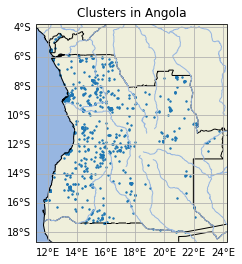

In [274]:
# plot all clusters
plot_locs(df_coord.to_numpy(), figsize=(4, 4), title='Clusters in Angola')
plt.show()

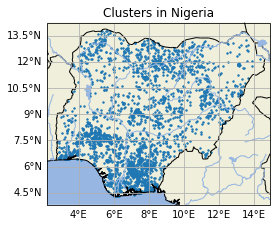

In [395]:
# plot all clusters
plot_locs(df_coord.to_numpy(), figsize=(4, 4), title='Clusters in Nigeria')
plt.show()

In [396]:
df_coord_year1 = df_years[0][['lat', 'lon']]

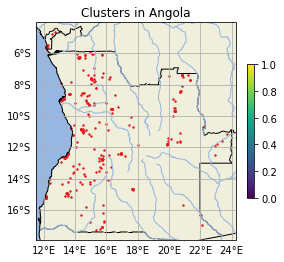

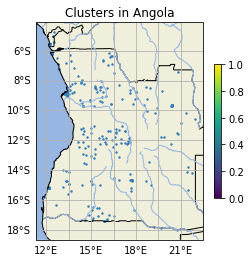

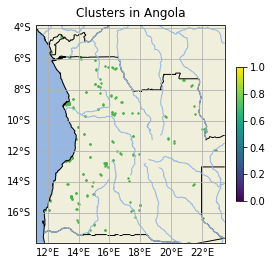

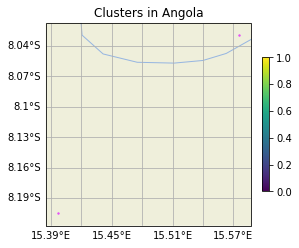

In [283]:
# plot the clusters from year 1
colors = ['#e41a1c', '#377eb8', '#4daf4a', '#e553f5']
i = 0
for df_year in df_years:
    plot_locs(df_year[['lat', 'lon']].to_numpy(), figsize=(4, 4), title='Clusters in Angola', colors = colors[i])
    i = i + 1
    plt.show()

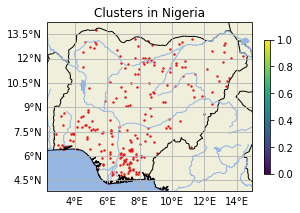

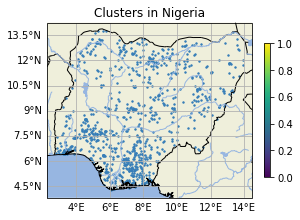

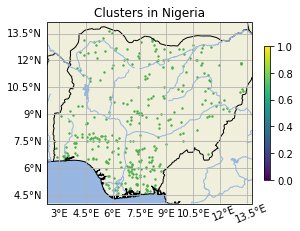

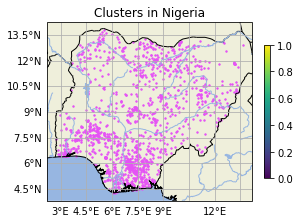

In [397]:
# plot the clusters from year 1
colors = ['#e41a1c', '#377eb8', '#4daf4a', '#e553f5']
i = 0
for df_year in df_years:
    plot_locs(df_year[['lat', 'lon']].to_numpy(), figsize=(4, 4), title='Clusters in Nigeria', colors = colors[i])
    i = i + 1
    plt.show()

In [362]:
df_angola_filtered = df_country[(df_country['dist_year0'] < 10) | (df_country['dist_year1'] < 10) | (df_country['dist_year2'] < 10) | (df_country['dist_year3'] < 10)]

In [406]:
df_nigeria_filtered = df_country[(df_country['dist_year0'] < 10) | (df_country['dist_year1'] < 10) | (df_country['dist_year2'] < 10) | (df_country['dist_year3'] < 10)]

In [363]:
df_angola_filtered

,country,ClusterID,households,lat,lon,wealth_pooled,year,month,RegionID,dist_year0,...,wealth_year0,dist_year1,index_year1,wealth_year1,dist_year2,index_year2,wealth_year2,dist_year3,index_year3,wealth_year3
0,Angola,AO.Bengo.71.135,127,-8.589805,13.640789,52.905026,2015,11,AO.Bengo,0.000000,...,52.905026,3.105909,15,50.785867,455.688967,55,17.888252,0.000000,0,52.905026
2,Angola,AO.Bengo.71.169,72,-8.592545,13.654425,48.056204,2015,10,AO.Bengo,109.585134,...,29.346399,2.652030,15,50.785867,455.519153,55,17.888252,1.531317,0,52.905026
7,Angola,AO.Bengo.71.224,128,-8.702282,13.449153,59.842942,2016,1,AO.Bengo,203.748512,...,23.963373,9.369182,3,42.719684,258.978347,212,58.924893,24.487192,0,52.905026
12,Angola,AO.Bengo.71.34,140,-8.586355,13.656795,49.865618,2015,11,AO.Bengo,25.520884,...,48.949183,1.928162,15,50.785867,108.858415,1,29.346399,1.802776,0,52.905026
15,Angola,AO.Bengo.71.399,126,-8.569210,13.659970,50.785867,2015,11,AO.Bengo,27.477678,...,59.842942,0.000000,15,50.785867,107.023406,1,29.346399,3.105909,0,52.905026
19,Angola,AO.Bengo.71.468,139,-8.572583,13.665589,50.385740,2015,11,AO.Bengo,20.903284,...,41.080772,0.722349,15,50.785867,107.058739,1,29.346399,3.328819,0,52.905026
25,Angola,AO.Bengo.71.549,99,-8.608122,13.614845,43.585744,2016,1,AO.Bengo,3.501394,...,52.905026,6.572337,15,50.785867,453.431898,55,17.888252,3.501394,0,52.905026
27,Angola,AO.Bengo.71.573,138,-8.582921,13.644828,63.619402,2015,10,AO.Bengo,107.468210,...,27.171139,2.253445,15,50.785867,456.486026,55,17.888252,0.881678,0,52.905026
179,Angola,AO.Cuanza Norte.71.325,98,-9.493850,14.362298,26.946244,2016,2,AO.Cuanza Norte,0.000000,...,26.946244,495.296474,101,43.208441,424.302159,80,39.264433,127.633634,0,52.905026
264,Angola,AO.Estavel Mesoendemica.62.10,191,-8.583901,13.664315,42.724989,2011,2,AO.Estavel Mesoendemica,26.388021,...,48.949183,1.693749,15,50.785867,108.230036,1,29.346399,2.670792,0,52.905026


In [407]:
df_nigeria_filtered

,country,ClusterID,households,lat,lon,wealth_pooled,year,month,RegionID,dist_year0,...,wealth_year0,dist_year1,index_year1,wealth_year1,dist_year2,index_year2,wealth_year2,dist_year3,index_year3,wealth_year3
18450,Nigeria,NG.North Central.61.1,166,6.732517,8.002321,29.861687,2010,11,NG.North Central,0.000000,...,29.861687,527.158630,540,47.320981,427.897333,189,43.722314,67.617169,171,22.462429
18451,Nigeria,NG.North Central.61.10,94,9.088659,7.320356,47.453755,2010,12,NG.North Central,0.000000,...,47.453755,220.404089,95,33.566643,266.225033,15,42.671716,313.583104,188,42.525001
18452,Nigeria,NG.North Central.61.11,58,9.119989,7.431838,59.113591,2010,11,NG.North Central,0.000000,...,59.113591,190.625905,87,20.051677,292.581539,13,28.264921,317.068310,195,42.177199
18453,Nigeria,NG.North Central.61.12,98,7.627060,7.247781,25.396786,2010,11,NG.North Central,0.000000,...,25.396786,73.805640,115,35.213027,167.110706,49,30.658605,234.749773,231,35.374902
18454,Nigeria,NG.North Central.61.13,105,8.220897,6.166906,22.504124,2010,11,NG.North Central,0.000000,...,22.504124,83.504307,121,41.374073,271.806142,47,32.117837,260.124505,242,29.910395
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18955,Nigeria,NG.North Central.7A.89,83,7.619268,6.211213,37.529934,2018,9,NG.North Central,5.430741,...,39.838977,259.918677,106,43.290551,214.610714,43,42.331374,308.257990,237,50.411101
18956,Nigeria,NG.North Central.7A.9,145,7.688504,8.503305,53.541791,2018,9,NG.North Central,9.291421,...,56.363574,100.683853,33,27.253215,83.408690,35,40.970856,5.249696,238,60.598099
18957,Nigeria,NG.North Central.7A.90,138,7.562246,6.209558,35.862840,2018,9,NG.North Central,2.686096,...,39.838977,258.107657,106,43.290551,218.894065,43,42.331374,245.886939,239,21.172130
18958,Nigeria,NG.North Central.7A.91,121,7.536485,6.276362,49.831990,2018,9,NG.North Central,3.920799,...,46.294843,212.256706,128,61.672427,314.611492,46,27.867684,171.711443,240,36.389262


Plot showing how asset wealth index has changed for the clusters over time in Angola

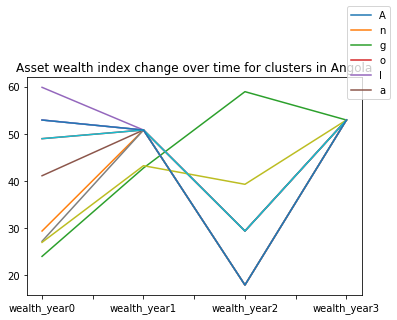

In [365]:
fig, ax = plt.subplots()

for index, row in df_angola_filtered.iterrows():
    row[['wealth_year0', 'wealth_year1', 'wealth_year2', 'wealth_year3']].plot(kind='line', ax=ax).plot(kind='line', ax=ax)
    ax.legend(row[0], loc=0, bbox_to_anchor=(1.1, 1.35));
plt.title('Asset wealth index change over time for clusters in Angola');

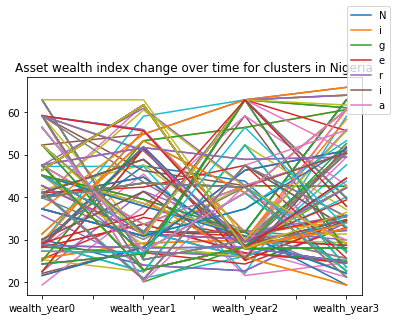

In [408]:
fig, ax = plt.subplots()

for index, row in df_nigeria_filtered.iterrows():
    row[['wealth_year0', 'wealth_year1', 'wealth_year2', 'wealth_year3']].plot(kind='line', ax=ax).plot(kind='line', ax=ax)
    ax.legend(row[0], loc=0, bbox_to_anchor=(1.1, 1.35));
plt.title('Asset wealth index change over time for clusters in Nigeria');

Plot showing how asset wealth index is changed over time

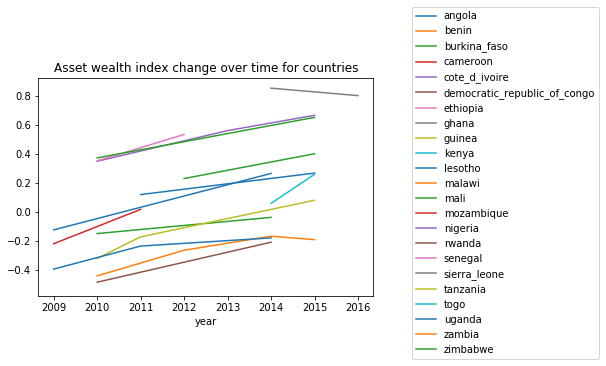

In [284]:
fig, ax = plt.subplots()
for country in clusters_df['country'].unique():
    country_df = clusters_df[clusters_df['country'] == country]
    country_by_year = country_df.groupby(['year']).mean()
    country_by_year['wealthpooled'].plot(kind='line', ax=ax)
    ax.legend(clusters_df['country'].unique(), loc=0, bbox_to_anchor=(1.1, 1.35));
plt.title('Asset wealth index change over time for countries');

In [87]:
cool_df = clusters_df.groupby(['country', 'year']).mean()

In [89]:
cool_df['wealthpooled']
    

country                       year
angola                        2011    0.122215
                              2015    0.270364
benin                         2012    0.200553
burkina_faso                  2010   -0.146392
                              2014   -0.034780
cameroon                      2011    0.297327
cote_d_ivoire                 2012    0.477785
democratic_republic_of_congo  2013   -0.506605
ethiopia                      2010   -0.450725
ghana                         2014    0.855409
                              2016    0.804072
guinea                        2012    0.101090
kenya                         2014    0.061579
                              2015    0.261875
lesotho                       2009   -0.121158
                              2014    0.267961
malawi                        2010   -0.437852
                              2012   -0.261324
                              2014   -0.164519
                              2015   -0.188475
mali                     

In [12]:
angola_df = clusters_df[clusters_df['country'] == 'angola']
angola_2011 = angola_df[angola_df['year'] == 2011]
angola_2015 = angola_df[angola_df['year'] == 2015]
# mean per country per year

lat        lon  wealthpooled  \
country                      year                                       
angola                       2011 -10.891445  15.189450      0.122215   
                             2015 -10.718080  15.586064      0.270364   
benin                        2012   7.757650   2.237945      0.200553   
burkina_faso                 2010  12.221145  -1.909577     -0.146392   
                             2014  12.161003  -1.919876     -0.034780   
cameroon                     2011   5.744451  11.667186      0.297327   
cote_d_ivoire                2012   7.010525  -5.222275      0.477785   
democratic_republic_of_congo 2013  -3.268139  22.682453     -0.506605   
ethiopia                     2010   9.661990  38.718503     -0.450725   
ghana                        2014   7.215853  -1.071828      0.855409   
                             2016   7.189403  -1.106107      0.804072   
guinea                       2012  10.267359 -11.816209      0.101090   
kenya                        2014  -0.404252  36.740044      0.061579   
                             2015  -0.567354  36.755563      0.261875   
lesotho                      2009 -29.524140  28.061915     -0.121158   
                             2014 -29.524077  28.052569      0.267961   
malawi                       2010 -14.123835  34.495702     -0.437852   
                             2012 -14.176805  34.462321     -0.261324   
                             2014 -13.653414  34.301566     -0.164519   
                             2015 -14.102016  34.517602     -0.188475   
mali                         2012  13.164266  -6.992970      0.232781   
                             2015  13.220496  -6.852854      0.403508   
mozambique                   2009 -19.126102  35.418111     -0.216493   
                             2011 -19.437539  35.214767      0.020327   
nigeria                      2010   8.294328   7.444367      0.351732   
                             2013   8.494743   7.305336      0.562958   
                             2015   8.429556   7.246627      0.668510   
rwanda                       2010  -2.008512  29.853829     -0.481522   
                             2014  -2.011523  29.860766     -0.205886   
senegal                      2010  14.261869 -15.478897      0.354166   
                             2012  14.282484 -15.507172      0.536270   
sierra_leone                 2013   8.396463 -12.018036     -0.159722   
tanzania                     2010  -5.833589  36.210667     -0.317913   
                             2011  -5.855345  35.718247     -0.169164   
                             2015  -5.828013  35.694310      0.083035   
togo                         2013   7.934778   1.021594      0.313965   
uganda                       2009   1.030291  32.323541     -0.391447   
                             2011   1.085648  32.330496     -0.232555   
                             2014   1.199302  32.467925     -0.176288   
zambia                       2013 -13.195091  28.624393      0.108498   
zimbabwe                     2010 -18.886674  30.301592      0.374875   
                             2015 -18.862497  30.319630      0.654183   

                                   households  urban_rural  
country                      year                           
angola                       2011   33.669565     0.404348  
                             2015   24.091200     0.552000  
benin                        2012   23.197051     0.415550  
burkina_faso                 2010   24.992606     0.316081  
                             2014   25.056452     0.209677  
cameroon                     2011   24.149306     0.510417  
cote_d_ivoire                2012   26.689150     0.469208  
democratic_republic_of_congo 2013   33.605691     0.321138  
ethiopia                     2010   27.761821     0.285464  
ghana                        2014   27.436019     0.511848  
                             2016   28.833333     0.500000  
guinea                       2012  

In [11]:
angola_2011['wealthpooled'].mean()

0.1222153641445484

In [13]:
angola_2015['wealthpooled'].mean()

0.27036411802433424

In [50]:
#!pip install geopandas

In [51]:
#!pip install contextily

In [52]:
#!pip install geovoronoi

In [54]:
#!pip install cartopy

In [55]:
#!pip install geoplot

In [56]:
#!pip install geovoronoi

In [69]:
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
from shapely.ops import cascaded_union
from geovoronoi.plotting import subplot_for_map, plot_voronoi_polys_with_points_in_area
from geovoronoi import voronoi_regions_from_coords, points_to_coords
import geoplot
import geoplot.crs as gcrs

/Users/juliaortheden/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
/Users/juliaortheden/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:167: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#d

In [70]:
import warnings; 
warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning) 

In [71]:
from shapely.geometry import Point

In [8]:
clusters_df.lat[1]

-12.360864999999999

/Users/juliaortheden/opt/anaconda3/lib/python3.7/site-packages/geopandas/geodataframe.py:852: UserWarning: Geometry column does not contain geometry.
  warnings.warn("Geometry column does not contain geometry.")


Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7fb675a07170> (for post_execute):


KeyboardInterrupt: 

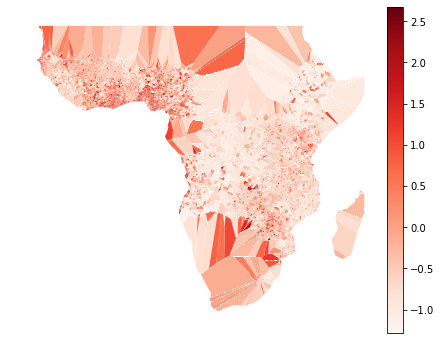

In [58]:
world = gpd.read_file(
    gpd.datasets.get_path('naturalearth_lowres')
)
africa = world.query('continent == "Africa"')
#ax = geoplot.cartogram(
#    africa, scale='pop_est', limits=(0.2, 1),
#    edgecolor='None', figsize=(7, 8)
#)


#points = Point(clusters_df.lat[1], clusters_df.lon[1])

geometry = [Point(xy) for xy in zip(clusters_df.lon, clusters_df.lat)]
gdf = gpd.GeoDataFrame(clusters_df, geometry=geometry)

# Set the map projection
proj = geoplot.crs.Mercator()

# Setup the Voronoi axes; this creates the Voronoi regions
ax = geoplot.voronoi(gdf,  # Define the GeoPandas DataFrame
                     hue='wealthpooled',  # df column used to color regions
                     clip=africa,  # Define the voronoi clipping (map edge)
                     projection=proj,  # Define the Projection
                     cmap='Reds',  # color seed
                     legend=True, # Create a legend
                     edgecolor='white',  # Color of the voronoi boundaries
                     linewidth=0.01  # width of the voronoi boundary lines
)

#geoplot.polyplot(africa, edgecolor='gray', facecolor='lightgray')

/Users/juliaortheden/opt/anaconda3/lib/python3.7/site-packages/geopandas/geodataframe.py:852: UserWarning: Geometry column does not contain geometry.
  warnings.warn("Geometry column does not contain geometry.")


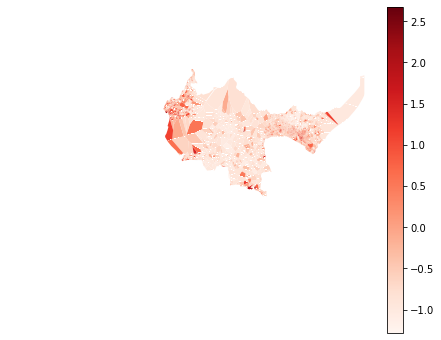

In [21]:
world = gpd.read_file(
    gpd.datasets.get_path('naturalearth_lowres')
)
africa = world.query('continent == "Africa"')
#ax = geoplot.cartogram(
#    africa, scale='pop_est', limits=(0.2, 1),
#    edgecolor='None', figsize=(7, 8)
#)

africa = africa.cx[:, 3:0]

geometry = [Point(xy) for xy in zip(clusters_df.lon, clusters_df.lat)]
gdf = gpd.GeoDataFrame(clusters_df, geometry=geometry)

# Set the map projection
proj = geoplot.crs.Mercator()

# Setup the Voronoi axes; this creates the Voronoi regions
ax = geoplot.voronoi(gdf,  # Define the GeoPandas DataFrame
                     hue='wealthpooled',  # df column used to color regions
                     clip=africa,  # Define the voronoi clipping (map edge)
                     projection=proj,  # Define the Projection
                     cmap='Reds',  # color seed
                     legend=True, # Create a legend
                     edgecolor='white',  # Color of the voronoi boundaries
                     linewidth=0.01  # width of the voronoi boundary lines
)

#geoplot.polyplot(africa, edgecolor='gray', facecolor='lightgray')

Plot each survey location on the map of Africa

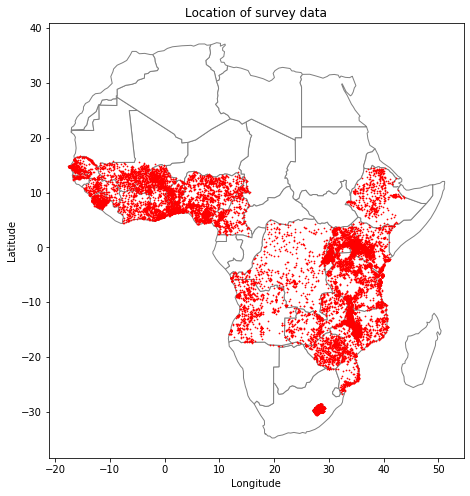

In [73]:
import matplotlib.pyplot as plt
import geopandas as gpd
from descartes import PolygonPatch

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

def plotCountryPatch( axes, country_name, fcolor ):
    # plot a country on the provided axes
    nami = world[world.name == country_name]
    namigm = nami.__geo_interface__['features']  # geopandas's geo_interface
    namig0 = {'type': namigm[0]['geometry']['type'], \
              'coordinates': namigm[0]['geometry']['coordinates']}
    axes.add_patch(PolygonPatch( namig0, fc=fcolor, ec="black", alpha=0.85, zorder=2 ))

# plot the whole world
#ax2 = world.plot( figsize=(8,4), edgecolor=u'gray', cmap='Set2' )

proj = geoplot.crs.Mercator()

# or plot Africa continent
ax2 = world[world.continent == 'Africa'].plot(figsize=(8,8), edgecolor=u'gray', color='white')#cmap='magma')

# then plot some countries on top
#plotCountryPatch(ax2, 'Namibia', 'red')
#plotCountryPatch(ax2, 'Libya', 'green')

geometry = [Point(xy) for xy in zip(clusters_df.lon, clusters_df.lat)]
gdf = gpd.GeoDataFrame(clusters_df, geometry=geometry)

gdf.plot(ax=ax2, color='red', markersize=0.5, legend=True)


# the place to plot additional vector data (points, lines)

plt.ylabel('Latitude')
plt.xlabel('Longitude')

plt.title('Location of survey data')
#ax2.axis('scaled')
plt.show()

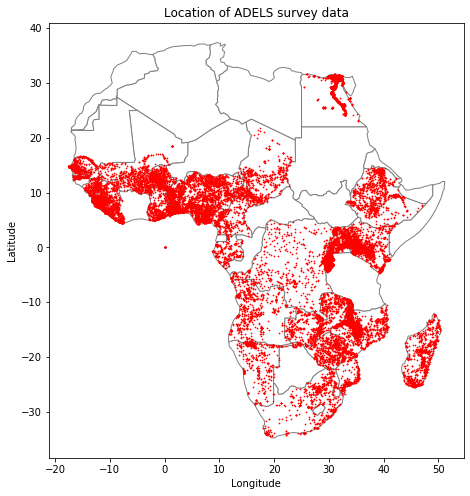

In [76]:
import matplotlib.pyplot as plt
import geopandas as gpd
from descartes import PolygonPatch

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

def plotCountryPatch( axes, country_name, fcolor ):
    # plot a country on the provided axes
    nami = world[world.name == country_name]
    namigm = nami.__geo_interface__['features']  # geopandas's geo_interface
    namig0 = {'type': namigm[0]['geometry']['type'], \
              'coordinates': namigm[0]['geometry']['coordinates']}
    axes.add_patch(PolygonPatch( namig0, fc=fcolor, ec="black", alpha=0.85, zorder=2 ))

# plot the whole world
#ax2 = world.plot( figsize=(8,4), edgecolor=u'gray', cmap='Set2' )

proj = geoplot.crs.Mercator()

# or plot Africa continent
ax2 = world[world.continent == 'Africa'].plot(figsize=(8,8), edgecolor=u'gray', color='white')#cmap='magma')

# then plot some countries on top
#plotCountryPatch(ax2, 'Namibia', 'red')
#plotCountryPatch(ax2, 'Libya', 'green')
geometry = [Point(xy) for xy in zip(df.lon, df.lat)]
gdf = gpd.GeoDataFrame(df, geometry=geometry)

gdf.plot(ax=ax2, color='red', markersize=0.5, legend=True)


# the place to plot additional vector data (points, lines)

plt.ylabel('Latitude')
plt.xlabel('Longitude')

plt.title('Location of ADELS survey data')
#ax2.axis('scaled')
plt.show()

Plot the number of surveys on the map


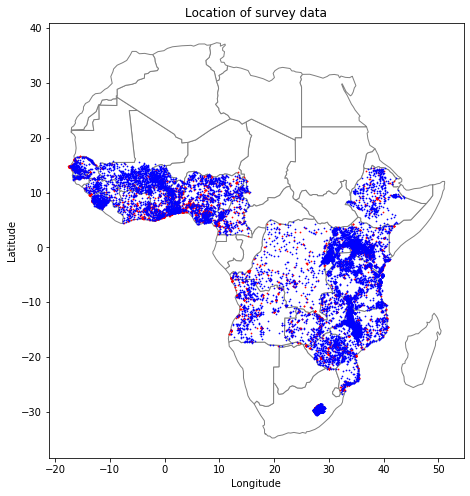

In [89]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# plot the whole world
#ax2 = world.plot( figsize=(8,4), edgecolor=u'gray', cmap='Set2' )

proj = geoplot.crs.Mercator()

# or plot Africa continent
ax2 = world[world.continent == 'Africa'].plot(figsize=(8,8), edgecolor=u'gray', color='white')#cmap='magma')

# then plot some countries on top
#plotCountryPatch(ax2, 'Namibia', 'red')
#plotCountryPatch(ax2, 'Libya', 'green')

urban_df = clusters_df[clusters_df['urban_rural'] == 1]

geometry = [Point(xy) for xy in zip(urban_df.lon, urban_df.lat)]
gdf = gpd.GeoDataFrame(urban_df, geometry=geometry)

gdf.plot(ax=ax2, color='red', markersize=0.5, legend=True)

rural_df = clusters_df[clusters_df['urban_rural'] == 0]

geometry = [Point(xy) for xy in zip(rural_df.lon, rural_df.lat)]
gdf = gpd.GeoDataFrame(rural_df, geometry=geometry)

gdf.plot(ax=ax2, color='blue', markersize=0.5, legend=True)



# the place to plot additional vector data (points, lines)

plt.ylabel('Latitude')
plt.xlabel('Longitude')

plt.title('Location of survey data')
#ax2.axis('scaled')
plt.show()

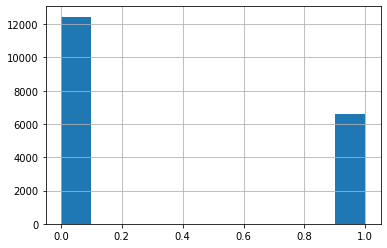

In [90]:
clusters_df['urban_rural'].hist()

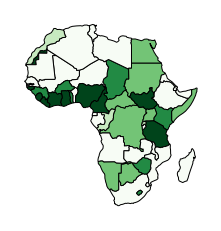

In [74]:
import mapclassify
wealth = clusters_df['wealthpooled']
scheme = mapclassify.Quantiles(wealth, k=5)

# Note: this code sample requires geoplot>=0.4.0.
geoplot.choropleth(
    africa, hue=wealth, scheme=scheme,
    cmap='Greens', figsize=(8, 4)
)

/Users/juliaortheden/opt/anaconda3/lib/python3.7/site-packages/mapclassify/classifiers.py:237: UserWarning: Warning: setting k to 17
  Warn("Warning: setting k to %d" % k_q, UserWarning)


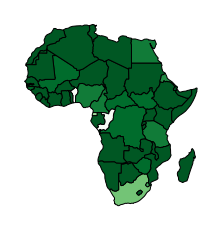

In [80]:
n_households = clusters_df['households']
scheme = mapclassify.Quantiles(n_households, k=25)

# Note: this code sample requires geoplot>=0.4.0.
geoplot.choropleth(
    africa, hue=n_households, scheme=scheme,
    cmap='Greens', figsize=(8, 4)
)

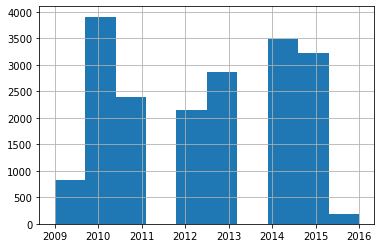

In [92]:
clusters_df['year'].hist()

In [185]:
clusters_df[clusters_df['country']=='angola']['year']

0      2011
1      2011
2      2011
3      2011
4      2011
       ... 
850    2015
851    2015
852    2015
853    2015
854    2015
Name: year, Length: 855, dtype: int64

In [101]:
ghana_df = clusters_df[clusters_df['country']=='ghana']

In [102]:
ghana_2016_df = ghana_df[ghana_df['year']==2016]

In [103]:
ghana_2014_df = ghana_df[ghana_df['year']==2014]

In [104]:
ghana_2016_df

,country,year,lat,lon,GID_1,GID_2,wealthpooled,households,urban_rural,geometry
4792,ghana,2016,5.076585,-2.887155,GHA.10,GHA.10.5,0.704634,30,0,POINT (-2.88715 5.07658)
4793,ghana,2016,5.286215,-2.763417,GHA.10,GHA.10.5,1.390819,29,1,POINT (-2.76342 5.28622)
4794,ghana,2016,4.916464,-2.174210,GHA.10,GHA.10.8,0.731194,29,0,POINT (-2.17421 4.91646)
4795,ghana,2016,4.914636,-1.781184,GHA.10,GHA.10.10,1.807246,29,1,POINT (-1.78118 4.91464)
4796,ghana,2016,4.924901,-1.753950,GHA.10,GHA.10.10,1.422209,29,1,POINT (-1.75395 4.92490)
...,...,...,...,...,...,...,...,...,...,...
4979,ghana,2016,10.947258,-2.168228,GHA.8,GHA.8.5,0.061642,29,0,POINT (-2.16823 10.94726)
4980,ghana,2016,10.917617,-2.655202,GHA.8,GHA.8.1,-0.223815,30,0,POINT (-2.65520 10.91762)
4981,ghana,2016,10.641916,-2.759454,GHA.8,GHA.8.2,-0.136469,30,0,POINT (-2.75945 10.64192)
4982,ghana,2016,10.640043,-2.882381,GHA.8,GHA.8.2,0.834113,30,1,POINT (-2.88238 10.64004)


In [105]:
ghana_2014_df

,country,year,lat,lon,GID_1,GID_2,wealthpooled,households,urban_rural,geometry
4370,ghana,2014,5.793782,-0.400936,GHA.4,GHA.4.3,0.536396,30,0,POINT (-0.40094 5.79378)
4371,ghana,2014,6.742562,-1.636748,GHA.1,GHA.1.16,1.826202,26,1,POINT (-1.63675 6.74256)
4372,ghana,2014,5.503744,-0.413996,GHA.3,GHA.3.7,1.414853,25,1,POINT (-0.41400 5.50374)
4373,ghana,2014,10.554068,0.038188,GHA.6,GHA.6.2,-0.170658,30,0,POINT (0.03819 10.55407)
4374,ghana,2014,6.725353,-1.586704,GHA.1,GHA.1.16,1.751851,28,1,POINT (-1.58670 6.72535)
...,...,...,...,...,...,...,...,...,...,...
4787,ghana,2014,6.493993,-0.952127,GHA.4,GHA.4.6,0.829967,28,0,POINT (-0.95213 6.49399)
4788,ghana,2014,6.896419,0.513165,GHA.9,GHA.9.3,1.112039,26,0,POINT (0.51316 6.89642)
4789,ghana,2014,6.653406,-1.585132,GHA.1,GHA.1.16,1.536749,30,1,POINT (-1.58513 6.65341)
4790,ghana,2014,10.056925,-2.484954,GHA.8,GHA.8.6,1.325197,27,1,POINT (-2.48495 10.05692)


In [124]:

ghana_2014_df = ghana_2014_df.reset_index()

In [121]:
ghana_2016_df = ghana_2016_df.reset_index()

In [145]:
def find_closest_point(point, point_list):
    min_dist = 10000
    min_point = None
    for neighbor in point_list:
        neighbor_dist = point.distance(neighbor)
        if  neighbor_dist < min_dist:
            min_point = neighbor
            min_dist = neighbor_dist
    return min_point  

In [180]:
def get_wealth_diff(df_2014, df_2016):
    wealth_diff_list = []
    for point in df_2014['geometry']:
        closest_point = find_closest_point(point, df_2016['geometry'])
        closest_point_wealth = df_2016[df_2016['geometry'] == closest_point]['wealthpooled']
        point_wealth = df_2014[df_2014['geometry'] == point]['wealthpooled']
        wealth_difference = closest_point_wealth.item() - point_wealth.item()
        wealth_diff_list.append(wealth_difference)
    return wealth_diff_list

In [183]:
wealth_list = get_wealth_diff(ghana_2014_df, ghana_2016_df)

In [184]:
np.array(wealth_list).mean()

-0.0036304596289043396

Try similar thing for Angola between 2011 and 2015


In [186]:
angola_df = clusters_df[clusters_df['country']=='angola']

In [188]:
angola_2015_df = angola_df[angola_df['year']==2015]

In [189]:
angola_2011_df = angola_df[angola_df['year']==2011]

In [190]:
wealth_list = get_wealth_diff(angola_2011_df, angola_2015_df)

In [191]:
np.array(wealth_list).mean()

0.40163195196174734